# Simple forecasting of COVID-19 using exponential and sigmoid functions

This repo uses report COVID-19 data provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) to estimate near term COVID-19 death rates around the world.  

Some notes:

  - We first define basic fit_exponential and fit_sigmoid functions that attempt to interpolate/fit the data provided.
  - Fitting exponentials allows a close fit in the early stages and help illustrate when the infection rate tends more linear.
  - As case numbers are dependent on testing - these are only useful if the total number of tests is known.  I'm not sure if this data is available or not.  At the moment we concentrate on Death rate data for each country, and specifically those countries with over 100 deaths make it into the rest-of-world data set.  Currently (29/3/2020) this is about 11% of the world population.  With this data it is then easy to extrapolate to get world totals or individual total mortality rates for certain countries based on either the rest of world historic sigmoid fits, or individual country sigmoid fits.  
  - Sigmoid function fitting.  So far (29/3/2020) we find that the sigmoid functions tend to fit the historic time series data very well - pretty much in all cases, but they are not good a providing a forecast until close to the inflection point, i.e., the point in time when infection rates start to decline.  
  - The inflection point is hard to predict as a number of countries are all in different stages of infection.  To gain estimates of how this might affect New Zealand, we use a rough population data set (where I've mapped the country names to match that of the COVID-19 data).  
  - For example, as of today, if New Zealand followed the Italian/Spanish death curve sigmoid fits, we could assume about 1000 deaths in New Zealand.  However, if we follow the rest-of-world curves, then this drops to around 400.  Obviously this does not take into account many other factors that appear to be important with this disease, for example; air pollution/smoking rates, age distribution, various social demographics etc.
  - a machine learning algo/linear model could be useful if we knew more - but I think the problem is we don't have enough historical data of other factors such as air polution, etc and of course social isolation curfews etc .
  - Another idea (below) is fitting a sigmoid curve to the integral of the death rate data for the rest of world.  The idea is that as different countries are at different stages of the disease/lock downs etc, we could assume that many distributed sigmoids end up canceling each other out, so that we get a prolonged linear growth rate, or constant death rate for some months until we reach a limit.  So far I've based the limit of the forecast data on the sigmoid fit for countries with over 100 deaths, or pop_pc % of world population.
  - Doing this is interesting as the fit of the sigmoid to the integral of the death rate data appears to fit well.  Currently forecasting to top out at over ~7000 deaths per day for 11% of world population.  If we assume that this rate continues linearly for the remainder of the world (all countries except China) then this could result in ~600,000 deaths either by mid June 2020, (assuming const. ~7000 deaths per day event), or by mid September 2020 using the standard sigmoid fit which currently peaks at its inflection point at around 3333 deaths per day soon - early April?.  Interpolating from the Chinese data, it will probably lie between these two.  But this changes with every new data point indicating this is not a very good forecast at the moment!

DJHume (latest update: 29/3/2020)


In [1]:
# COVID-19 forecasting - how will this impact NZ and NZ electricity demand in 2020?
import pandas as pd
%pylab inline
from datetime import date, datetime, time, timedelta
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


In [2]:
# get some nice colours and define better legend and plot formatting...

c_p = {'rd2': (0.9647058823529412, 0.5450980392156862, 0.6352941176470588), 'yl1': (1.0, 0.7294117647058823, 0.17647058823529413), 'gy2': (0.9098039215686274, 0.9098039215686274, 0.9098039215686274), 'bl2': (0.7176470588235294, 0.8901960784313725, 0.9725490196078431), 'yl2': (0.984313725490196, 0.8196078431372549, 0.5450980392156862), 'br1': (0.32941176470588235, 0.0, 0.0), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'rd1': (0.9294117647058824, 0.09019607843137255, 0.27058823529411763), 'gy1': (0.8235294117647058, 0.8235294117647058, 0.8235294117647058), 'br2': (0.6627450980392157, 0.5019607843137255, 0.5019607843137255)}
c_s = {'og1': (0.8235294117647058, 0.38823529411764707, 0.10196078431372549), 'yl1': (0.803921568627451, 0.8156862745098039, 0.0), 'or1': (1.0, 0.4823529411764706, 0.0), 'pp1': (0.27058823529411763, 0.1803921568627451, 0.6745098039215687), 'mv1': (0.0, 0.4588235294117647, 0.4235294117647059), 'rd2': (0.8470588235294118, 0.5882352941176471, 0.5019607843137255), 'pr1': (0.803921568627451, 0.34901960784313724, 1.0), 'pk2': (1.0, 0.7372549019607844, 0.8313725490196079), 'gr1': (0.00784313725490196, 0.4666666666666667, 0.2196078431372549), 'or2': (1.0, 0.7372549019607844, 0.5019607843137255), 'mv2': (0.5019607843137255, 0.7254901960784313, 0.7098039215686275), 'pp2': (0.6862745098039216, 0.6431372549019608, 0.7411764705882353), 'gn1': (0.3803921568627451, 0.7372549019607844, 0.22745098039215686), 'bu1': (0.0, 0.5568627450980392, 1.0), 'bl2': (0.5254901960784314, 0.7372549019607844, 0.8392156862745098), 'ge1': (0.0, 0.7019607843137254, 0.6196078431372549), 'yl2': (0.8980392156862745, 0.9058823529411765, 0.5019607843137255), 'bu2': (0.5019607843137255, 0.7725490196078432, 1.0), 'ge2': (0.5019607843137255, 0.8470588235294118, 0.807843137254902), 'rd1': (0.7019607843137254, 0.18823529411764706, 0.0), 'gy1': (0.5843137254901961, 0.5843137254901961, 0.5843137254901961), 'og2': (0.8901960784313725, 0.6901960784313725, 0.5490196078431373), 'gy2': (0.788235294117647, 0.788235294117647, 0.788235294117647), 'be2': (0.8862745098039215, 0.9490196078431372, 0.984313725490196), 'pk1': (1.0, 0.3411764705882353, 0.9607843137254902), 'be1': (0.7803921568627451, 0.9019607843137255, 0.9803921568627451), 'gr2': (0.5019607843137255, 0.7294117647058823, 0.7098039215686275), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'gn2': (0.6862745098039216, 0.8666666666666667, 0.611764705882353), 'pr2': (0.8980392156862745, 0.6705882352941176, 1.0)}

def colours():
    mpl.rcParams['axes.prop_cycle'] = cycler('color', [c_p['br1'], c_p['br2'],
        c_p['bl1'], c_p['bl2'], c_p['yl1'], c_p['yl2'], c_p['rd1'], c_p['rd2'],
        c_p['gy1'], c_p['gy2'], c_s['pp1'], c_s['pp2'], c_s['pr1'], c_s['pr2'],
        c_s['gr1'], c_s['gr2'], c_s['gn1'], c_s['gn2'], c_s['pk1'], c_s['pk2'],
        c_s['yl1'], c_s['yl2'], c_s['mv1'], c_s['mv2']])

def legend_format(ax, cols=4, xpos=-0.021, ypos=-0.15, **kwargs):
    """Place legend outside of plot"""
    ax.legend(loc=3,
              bbox_to_anchor=(xpos, ypos),
              ncol=cols,
              frameon=False, **kwargs)

def plot_formatting(ax, rot=False, **kwargs):
    """A few tricks used for better looking plots"""
    ax.grid(b=True, which='major', color='k', linestyle='-',
            axis='y', alpha=0.6, clip_on=True, marker=None)
    ax.grid(b=False, axis='x', which='both')
    ax.set_frame_on(False)  # Remove plot frame
    ax.set_axisbelow(True)
    ax.xaxis.tick_bottom()
    plt.xticks(ax.get_xticks(), rotation=0, **kwargs)
    if rot:
        plt.xticks(ax.get_xticks(), rotation=90, **kwargs)
    else:
        plt.xticks(ax.get_xticks(), rotation=0, **kwargs) 
    
colours()

In [3]:
# Update data from the Johns Hopkins University Center for Systems Science and
# Engineering (JHU CSSE) github repo
#!git pull upstream master

In [117]:
# Read into Pandas DataFrames
#d_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv', index_col=[0, 1, 2, 3], parse_dates=True)
c_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', index_col=[0, 1, 2, 3], parse_dates=True)
r_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', index_col=[0, 1, 2, 3], parse_dates=True)
d_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', index_col=[0, 1, 2, 3], parse_dates=True)
# Convert columns to datetime objects
d_ts.columns = pd.to_datetime(d_ts.columns)
c_ts.columns = pd.to_datetime(c_ts.columns)
r_ts.columns = pd.to_datetime(r_ts.columns)

d_ts = d_ts.groupby(level=1, axis=0).sum().T
c_ts = c_ts.groupby(level=1, axis=0).sum().T
r_ts = r_ts.groupby(level=1, axis=0).sum().T
d_ts.loc["2020-03-12", "Italy"] = np.nan 
d_ts = d_ts.interpolate()

# China
C_D = d_ts["China"]
C_C = c_ts["China"]
C_R = r_ts["China"]

# RoW
RoW_D = d_ts.drop('China', axis=1).sum(axis=1)
RoW_C = c_ts.drop('China', axis=1).sum(axis=1)
RoW_R = r_ts.drop('China', axis=1).sum(axis=1)


RoW_D2 = d_ts.drop('China', axis=1)
# Linear interpolate unusual data
RoW_D2.loc['2020-03-12', 'Italy']=np.nan
RoW_D2.loc['2020-03-17', 'France']=np.nan
RoW_D2.loc['2020-03-18', 'France']=np.nan
RoW_D2.loc['2020-03-19', 'France']=np.nan
RoW_D2 = RoW_D2.interpolate()
RoW_D = RoW_D2.sum(axis=1)

# need country population data - this data appears old so scale up
pop = pd.read_csv("pop.csv", index_col=0)
pop = (pop*7.8E9/pop.sum()).population

In [118]:
RoW_D2.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
2020-03-26,4,6,25,3,0,0,9,1,13,49,...,5,2,580,0,0,0,0,1,0,1
2020-03-27,4,8,26,3,0,0,13,1,13,58,...,5,2,761,0,1,1,0,1,0,1
2020-03-28,4,10,29,3,0,0,18,1,14,68,...,9,2,1021,0,2,2,0,1,0,1
2020-03-29,4,10,31,6,2,0,19,3,16,86,...,10,3,1231,1,2,2,0,1,0,1
2020-03-30,4,11,35,8,2,0,23,3,17,108,...,13,5,1411,1,2,3,0,1,0,1


In [119]:
def fit_exp(df, start_date=datetime(2020, 1, 21), end_date=datetime(2020, 4, 20)):
    """Simple exponential forecast - essentially a straight line fit of the logs.
       This massively over estimates things in the long run but may be reasonably 
       accurate while in the early exponential phase of a pandemic.  It is still good to
       use to help see when we are deviating from the exponential"""
    def initialise_forecast(df, start_date=start_date, end_date=end_date):
        """given actual reported death rate data, start time, and forecast end time, return cropped reported data and forecast date range for forecasting"""
        df = df[start_date:]
        df = df.replace(0, np.nan).dropna()
        dates = list(df.index)
        date_forecast = pd.date_range(start_date, end_date).to_pydatetime()
        x = mdates.date2num(dates)
        x_forecast = mdates.date2num(date_forecast)
        return df, dates, x, x_forecast

    df, dates, x, x_forecast = initialise_forecast(df, start_date=start_date, end_date=end_date)
    ydata = df.values
    df_reported = pd.DataFrame({'Date': x, 'Reported': ydata})
    df_reported.set_index('Date', inplace=True)

    y = log(ydata)
    p4 = np.poly1d(np.polyfit(x, y, 1))

    xx = np.linspace(x.min(), x.max(), 100)
    xx_forecast = np.linspace(x_forecast.min(), x_forecast.max(), 1000)
    dd = mdates.num2date(xx)
    dd_forecast = mdates.num2date(xx_forecast)

    df = pd.DataFrame({'Date': dd, 'Fitted': exp(p4(xx))})
    df_reported = pd.DataFrame({'Date': dates, 'Reported': ydata})
    df.set_index('Date', inplace=True)
    df_reported.set_index('Date', inplace=True)
    df_forecast = pd.DataFrame({'Date': dd_forecast,
                                'Forecast': exp(p4(xx_forecast))})
    df_forecast.set_index('Date', inplace=True)
    df_forecast.index = df_forecast.index.map(lambda x: x.date())
    df_forecast = df_forecast.groupby(level=0).min()
    df_p = pd.DataFrame({'Reported': df_reported.Reported,
                        'Forecast': df_forecast.Forecast}, index=df_forecast.index)

    df_p.index = pd.to_datetime(df_p.index)
    return df_p

# define some functions we will use to curve fit and forecast COVID-19 deaths...

def fit_sigmoid(df, start_date=datetime(2020, 1, 21), end_date=datetime(2020, 3, 31),
                p0=None):
    """Attempt to fit a sigmoid function to actual data, the outputs (popt, pcov) 
       are then used in forecast..."""

    def sigmoid(x, L ,x0, k, b):
        """https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python"""
        y = L / (1 + np.exp(-k*(x-x0)))+b
        return (y)

    def initialise_forecast(df, start_date=start_date, end_date=end_date):
        """given actual reported death rate data, start time, and forecast end time, return cropped reported data and forecast date range for forecasting"""
        df = df[start_date:]
        dates = list(df.index)
        date_forecast = pd.date_range(start_date, end_date).to_pydatetime()
        x = mdates.date2num(dates)
        x_forecast = mdates.date2num(date_forecast)
        return df, x, x_forecast

    df, x, x_forecast = initialise_forecast(df, start_date=start_date, end_date=end_date)
    dates = list(df.index)
    xdata = mdates.date2num(dates)
    ydata = df.values
    df_reported = pd.DataFrame({'Date': dates, 'Reported': ydata})
    df_reported.set_index('Date', inplace=True)

    if not p0:
        p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    print(p0)
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    
    y_forecast = sigmoid(x_forecast, *popt)
    
    xx_forecast = pd.to_datetime(mdates.num2date(x_forecast))
    xx_forecast = xx_forecast.map(lambda x: x.date())

    
    
    df_p = pd.DataFrame({'Forecast': y_forecast, 
                        'Reported': df_reported.Reported}, index=xx_forecast)
    df_p.index = pd.to_datetime(df_p.index)
    return df_p  #y_forecast, xx_forecast


def exp_vs_reported_v2(d_ts, 
                    C_start=datetime(2020, 1, 21), RoW_start=datetime(2020,2, 23)):
    """return dataframe of exponential fit and reported data for China and selected countries"""
    df_dict = {}
    for c in d_ts.columns:
        df_dict[c] = fit_exp(d_ts[c], start_date=datetime.now()-timedelta(days=16))
    df = pd.concat(df_dict.values(), axis=1, keys=df_dict.keys())
    return df

def exp_vs_reported(d_ts, countries=['Italy', 'Iran', 'Korea, South', 'China', 'Spain', 'US'], 
                    C_start=datetime(2020, 1, 21), RoW_start=datetime(2020,2, 23)):
    """return dataframe of exponential fit and reported data for China and selected countries"""
    df_dict = {}
    for c in countries:
        if c != 'China':
            df_dict[c] = fit_exp(d_ts[c], start_date=RoW_start)
        else:
            df_dict[c] = fit_exp(d_ts[c][C_start:], start_date=C_start)
    df = pd.concat(df_dict.values(), axis=1, keys=df_dict.keys())
    return df

### China death rate data follows a sigmoid (S-curve function)

https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python

https://en.wikipedia.org/wiki/Logistic_function

We need to fit to this, then apply to the RoW data.

Chinese data looks like topping out at <4000 total deaths.  

But China was aggressive with containment, so this might be a best case scenario when applied to the rest of the world.
This helps validate the sigmoid function for use of forecasting... although forecasts are better beyond the inflection point.


[3308, 737480.0, 1, 17]
[3308, 737480.0, 1, 17]
[3308, 737480.0, 1, 17]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


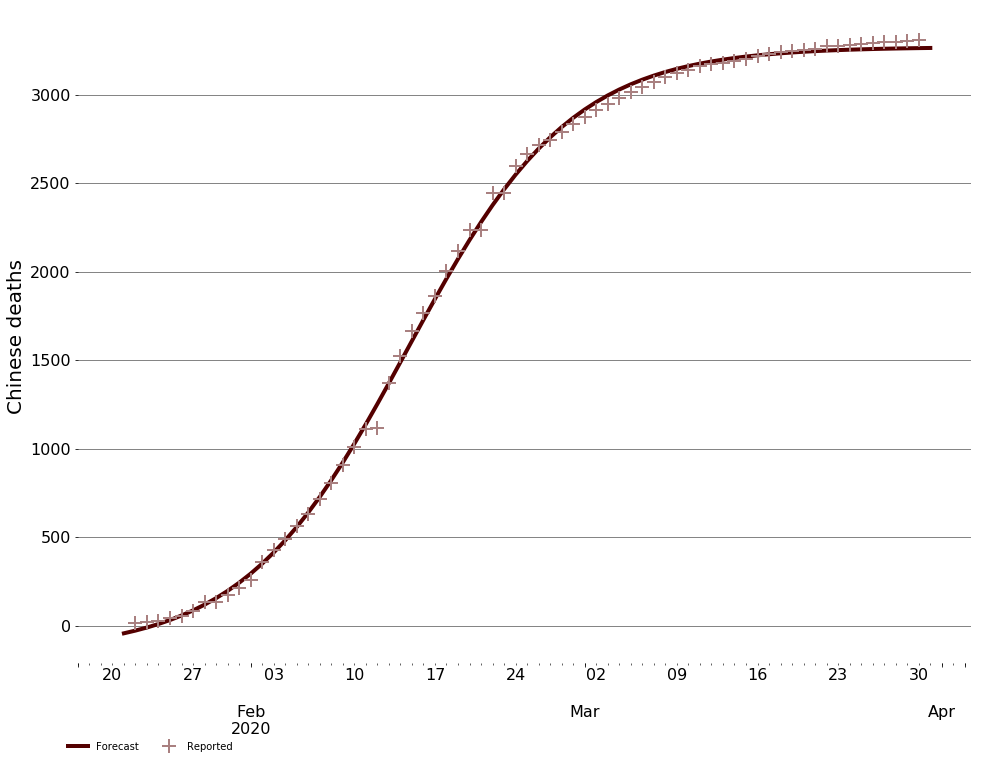

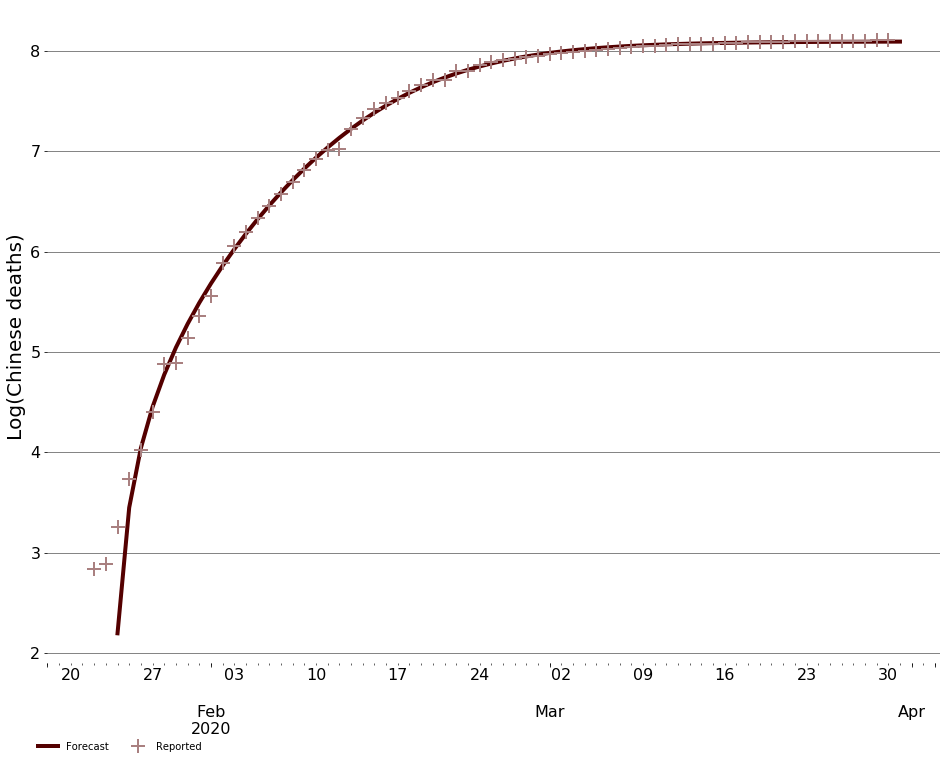

In [120]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
C_D_fitted = fit_sigmoid(C_D)
C_D_fitted.Forecast.plot(ax=ax, lw=4, fontsize=16, label='Forecast')
C_D_fitted.Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2, label='Reported')
grid('on')
ax.set_ylabel('Chinese deaths', fontsize=20)
legend_format(ax)
plot_formatting(ax)

fig = plt.figure(2, figsize=[16,12])
ax = fig.add_subplot(111)
log(fit_sigmoid(C_D).Forecast).plot(ax=ax, lw=4, fontsize=16)
log(fit_sigmoid(C_D).Reported).plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
ax.set_ylabel('Log(Chinese deaths)', fontsize=20)
grid('on')

legend_format(ax)
plot_formatting(ax)

## Rest of World data

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


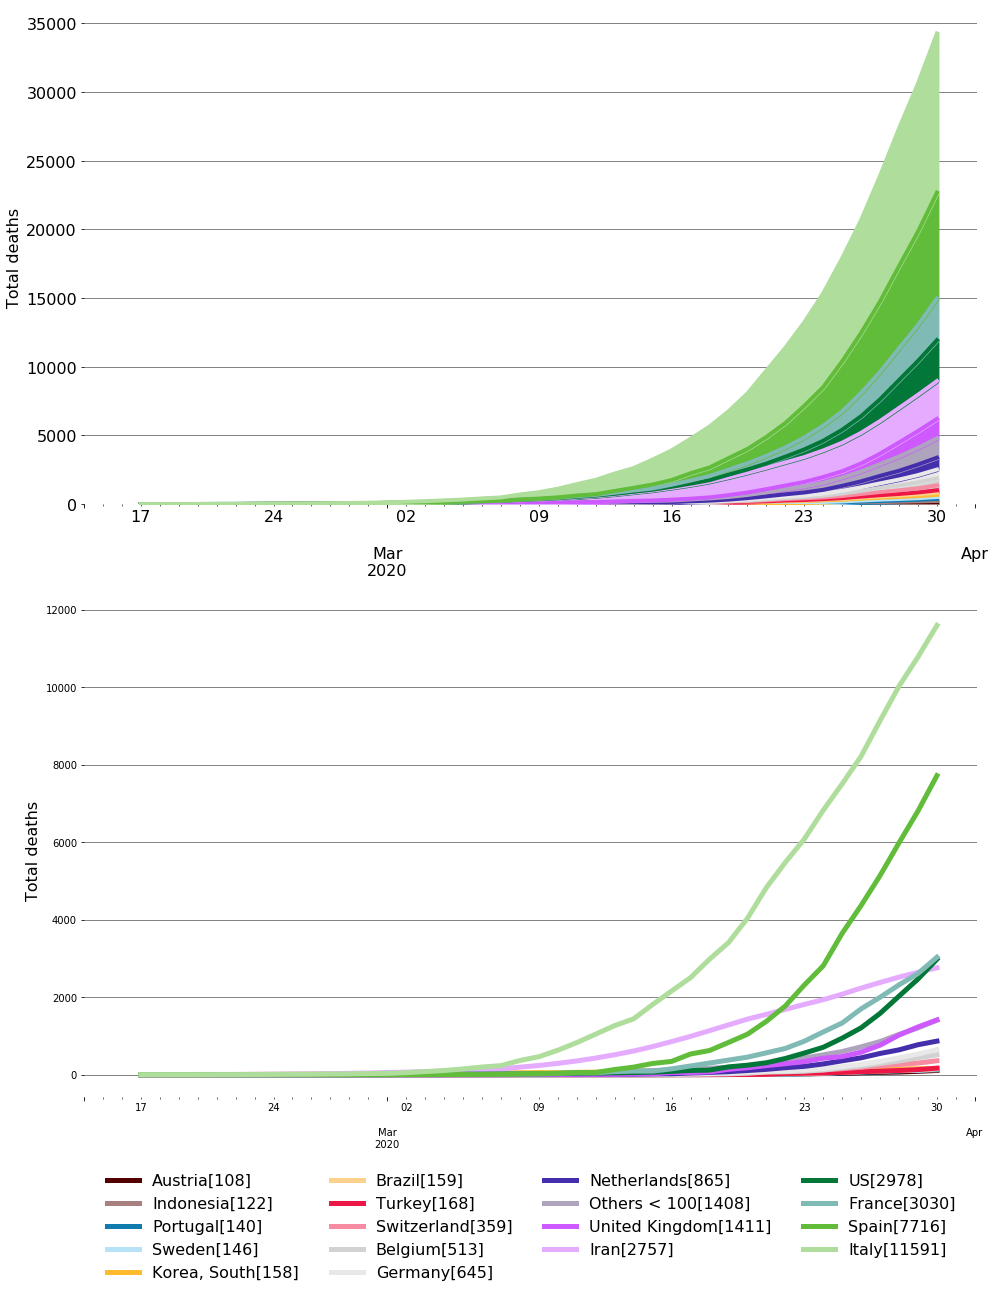

In [121]:
Cur_total_deaths = RoW_D2.tail(1).T.sort_values(by=RoW_D2.tail(1).T.columns[0])
death_lim = 100
RoW_lim = RoW_D2.loc[:, RoW_D2.iloc[-1,:] >= death_lim]

pop_total_with_more_than_100_deaths = pop[RoW_lim.columns].sum()
pop_pc = 100*pop_total_with_more_than_100_deaths/pop.sum()

RoW_lim['Others < ' + str(death_lim)] = RoW_D2.loc[:, RoW_D2.iloc[-1,:] < death_lim].sum(axis=1)
RoW_lim.columns = RoW_lim.iloc[-1,:].reset_index().apply(lambda x: x[0] + '[' + str(int(x[1])) + ']', axis=1)
RoW_lim = RoW_lim[RoW_lim.iloc[-1, :].sort_values().index]

strd = "2020/2/17"

fig = plt.figure(1, figsize=[16,20])
ax = fig.add_subplot(211)
RoW_lim[strd:].plot(kind='area', ax=ax, lw=4, fontsize=16)
ax.set_ylabel('Total deaths', fontsize=16)
ax.get_legend().remove()
plot_formatting(ax)
ax2 = fig.add_subplot(212)
RoW_lim[strd:].plot(ax=ax2, lw=5)
ax2.set_ylabel('Total deaths', fontsize=16)
plot_formatting(ax2)
legend_format(ax2, cols=4, ypos=-0.4, xpos=0.01, fontsize=16)

Text(0, 0.5, 'Total deaths (2020-03-30)')

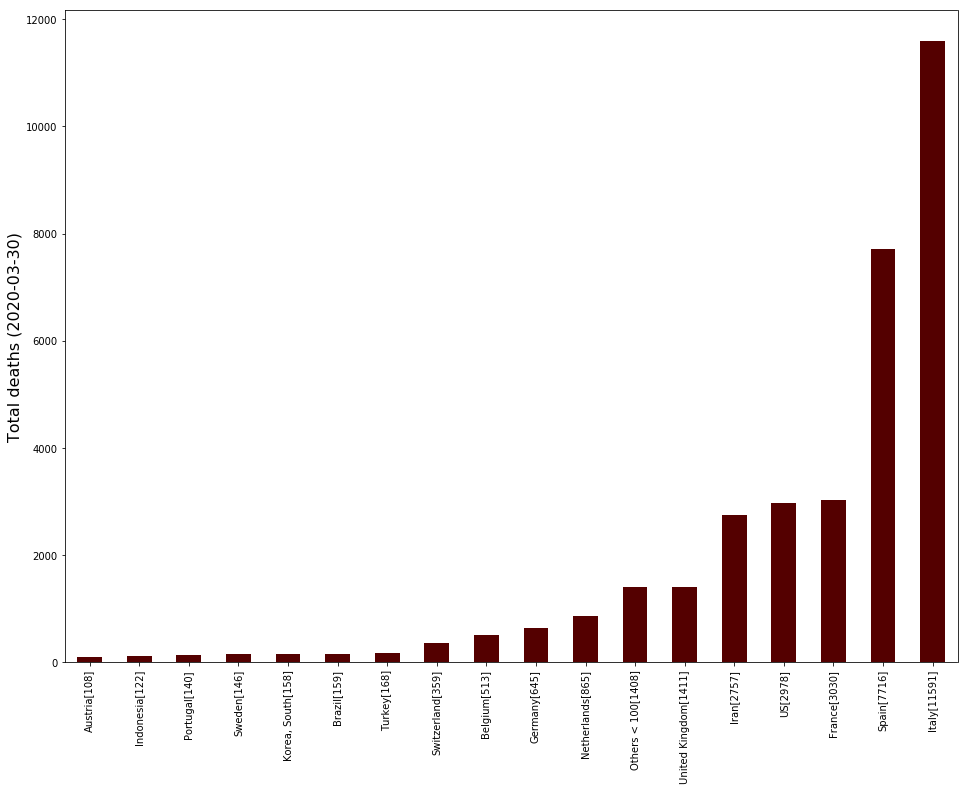

In [122]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
RoW_lim.iloc[-1,:].plot(kind='bar', ax=ax, color=c_p['br1'])
ax.set_ylabel('Total deaths (' + str(RoW_lim.tail(1).index[0].date()) + ')', fontsize=16)

In [123]:
RoW_D.tail()

2020-03-26    20679.0
2020-03-27    23902.0
2020-03-28    27353.0
2020-03-29    30621.0
2020-03-30    34274.0
dtype: float64

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0, 0.5, 'Italy exponential forecast and reported deaths')

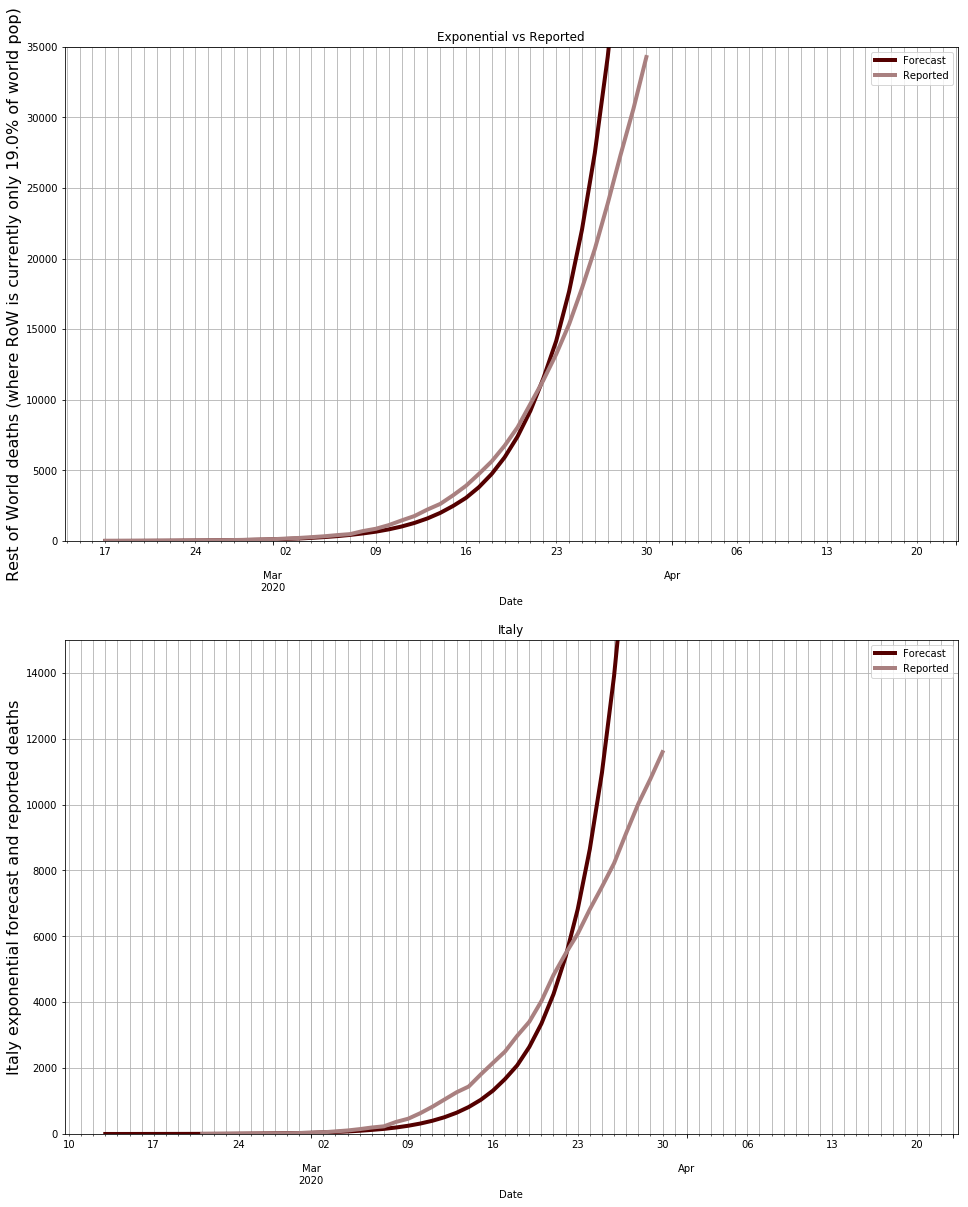

In [124]:

fig = plt.figure(1, figsize=[16,20])
ax = fig.add_subplot(211)
fit_exp(RoW_D, start_date=datetime(2020,2,17)).plot(ax=ax, lw=4)
ax.set_ylim([0, 35000])
ax.set_title('Exponential vs Reported')
grid('on', which='both')
ax.set_ylabel('Rest of World deaths (where RoW is currently only ' + str(pop_pc.round()) + '% of world pop)', fontsize=16)

ax2 = fig.add_subplot(212)
ax2.set_title('Italy')
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,13)).plot(ax=ax2, lw=4)
ax2.set_ylim([0, 15000])
ax2.grid('on', which='both')
ax2.set_ylabel('Italy exponential forecast and reported deaths', fontsize=16)




In [125]:
RoW_lim.head()

,Austria[108],Indonesia[122],Portugal[140],Sweden[146],"Korea, South[158]",Brazil[159],Turkey[168],Switzerland[359],Belgium[513],Germany[645],Netherlands[865],Others < 100[1408],United Kingdom[1411],Iran[2757],US[2978],France[3030],Spain[7716],Italy[11591]
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


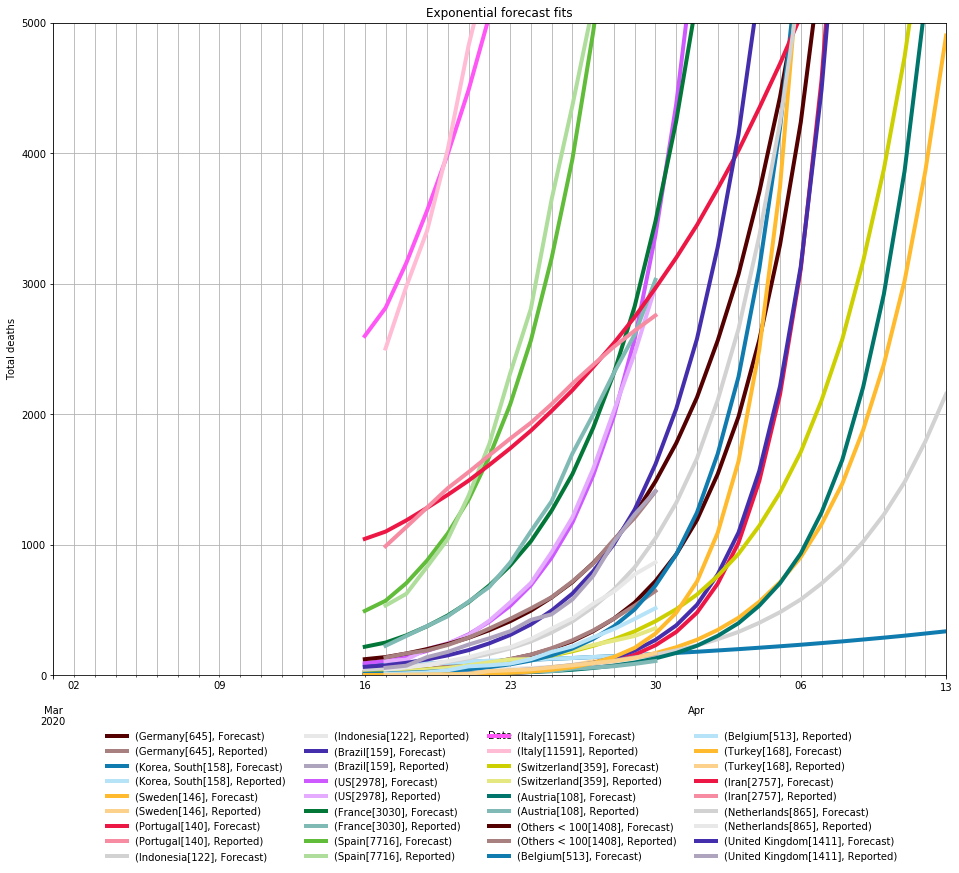

In [126]:
# Note Spain, Italy and US all above forecast exponential curves in initial stqges.
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
exp_forecast = exp_vs_reported_v2(RoW_lim,)
exp_f = exp_forecast["2020/3/01":"2020/4/13"]
exp_f.plot(ax=ax, lw=4)
ax.set_xlim([datetime(2020,3,1), datetime(2020,4,13)])
ax.set_ylim([0, 5000])
ax.grid('on', which='both')
ax.set_ylabel('Total deaths')
ax.set_title('Exponential forecast fits')
legend_format(ax, cols=4, ypos=-0.3, xpos=0.05)


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


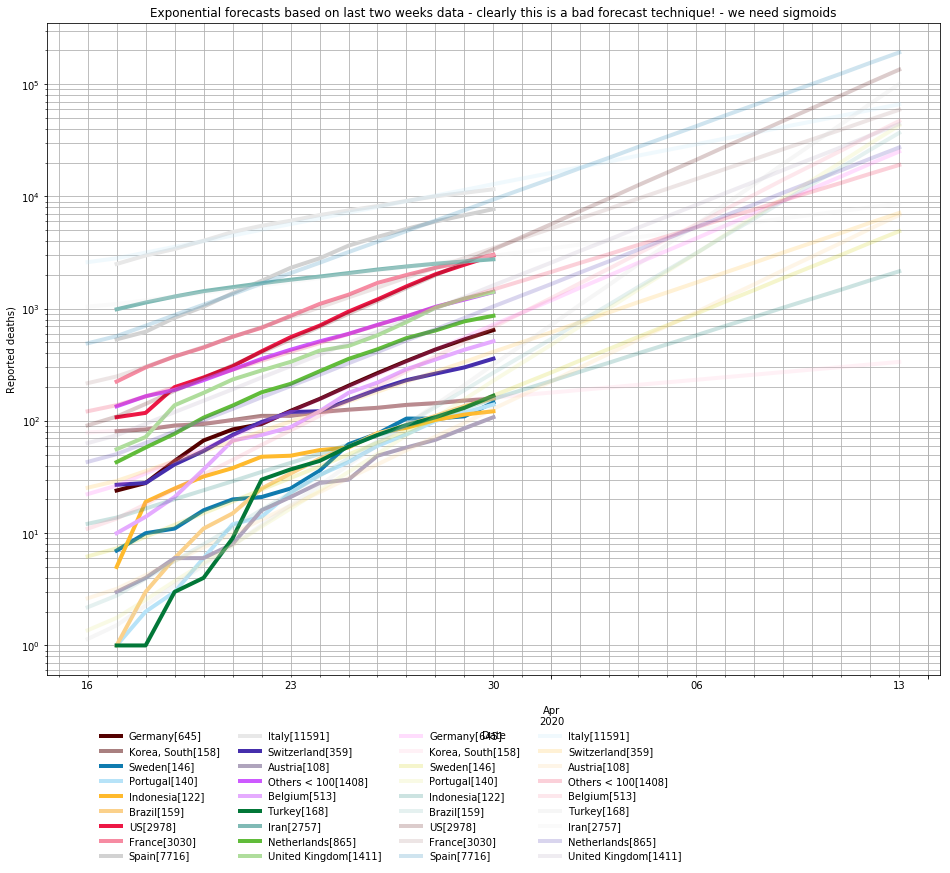

In [127]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
exp_f.xs('Reported', level=1, axis=1).plot(ax=ax, lw=4, logy=True)
exp_f.xs('Forecast', level=1, axis=1).plot(ax=ax, lw=4, logy=True, alpha=0.2)
#exp_f.plot(ax=ax, lw=4, logy=True)
ax.set_ylabel('Reported deaths)')
legend_format(ax, cols=4, ypos=-0.3, xpos=0.05)
ax.set_title('Exponential forecasts based on last two weeks data - clearly this is a bad forecast technique! - we need sigmoids')
ax.grid('on', which='both')

In [128]:

Countries_with_deaths = Cur_total_deaths[Cur_total_deaths>0].dropna().index
pop_total_with_deaths = pop.loc[Countries_with_deaths].sum()

Countries_with_more_than_100_deaths = Cur_total_deaths[Cur_total_deaths>100].dropna().index
pop_total_with_more_than_100_deaths = pop.loc[Countries_with_more_than_100_deaths].sum()



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
pop_total_with_more_than_100_deaths

1479699087.2337785

[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737505.0, 0.305, 10]
[375000, 737505.0, 0.305, 10]
[375000, 737505.0, 0.305, 10]
[34274.0, 737480.0, 1, 0.0]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


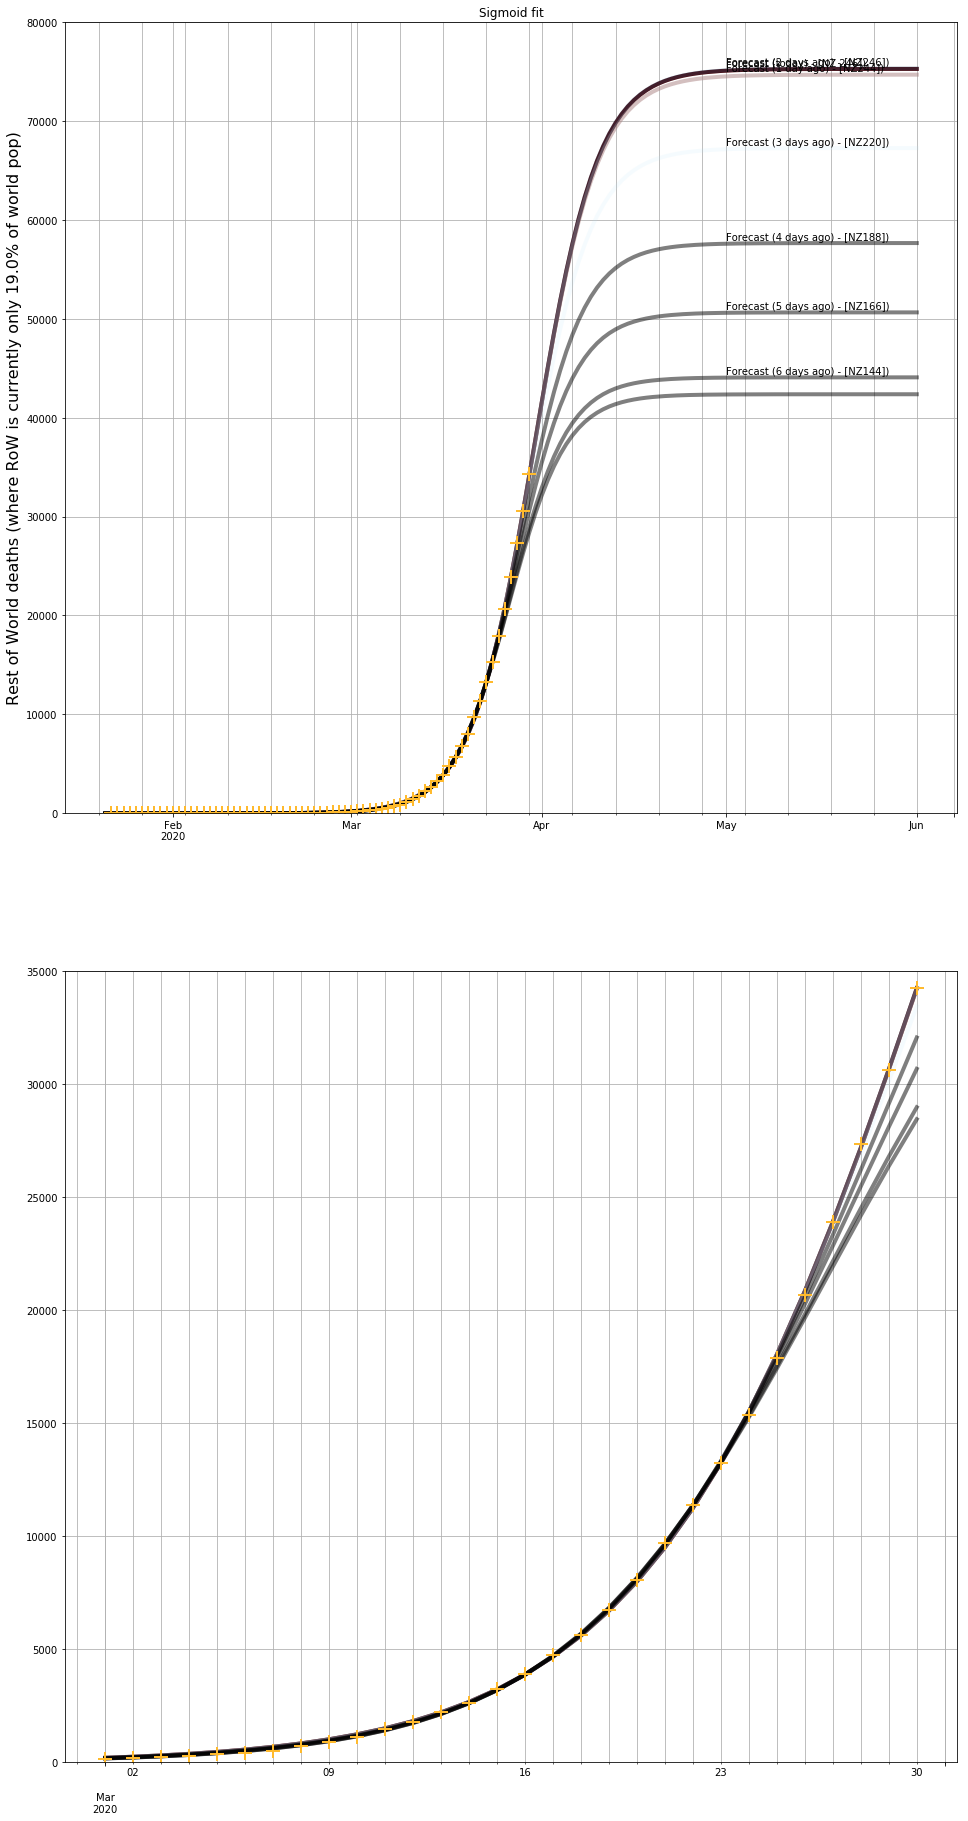

In [202]:
fig = plt.figure(1, figsize=[16,32])
ax = fig.add_subplot(211)
fs = fit_sigmoid(RoW_D, p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn1 = fit_sigmoid(RoW_D.iloc[:-1], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn2 = fit_sigmoid(RoW_D.iloc[:-2], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn3 = fit_sigmoid(RoW_D.iloc[:-3], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn4 = fit_sigmoid(RoW_D.iloc[:-4], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn5 = fit_sigmoid(RoW_D.iloc[:-5], p0=[375000, date2num(datetime(2020,3,21)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn6 = fit_sigmoid(RoW_D.iloc[:-6], p0=[375000, date2num(datetime(2020,3,21)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn7 = fit_sigmoid(RoW_D.iloc[:-7], p0=[375000, date2num(datetime(2020,3,21)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast

fs.index = pd.to_datetime(fs.index)
fsn1.index = pd.to_datetime(fsn1.index)
fsn2.index = pd.to_datetime(fsn2.index)
fsn3.index = pd.to_datetime(fsn3.index)
fsn4.index = pd.to_datetime(fsn4.index)
fsn5.index = pd.to_datetime(fsn5.index)
fsn6.index = pd.to_datetime(fsn6.index)
fsn7.index = pd.to_datetime(fsn7.index)

fs.plot(ax=ax, lw=4, )
fsn1.plot(ax=ax, lw=4, alpha=0.5)
fsn2.plot(ax=ax, lw=4, alpha=0.25)
fsn3.plot(ax=ax, lw=4, alpha=0.125)
fsn4.plot(ax=ax, lw=4, alpha=0.5, color='k')
fsn5.plot(ax=ax, lw=4, alpha=0.5, color='k')
fsn6.plot(ax=ax, lw=4, alpha=0.5, color='k')
fsn7.plot(ax=ax, lw=4, alpha=0.5, color='k')
ax.set_title('Sigmoid fit')
fs_r = fit_sigmoid(RoW_D).Reported
fs_r.index = pd.to_datetime(fs_r.index)
fs_r.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 80000])
# ax2 = fig.add_subplot(312)
# (fs*1).plot(ax=ax2, lw=4)
# fsn1.plot(ax=ax2, lw=4, alpha=0.5)
# fsn2.plot(ax=ax2, lw=4, alpha=0.25)
# fsn3.plot(ax=ax2, lw=4, alpha=0.125)
# fsn4.plot(ax=ax2, lw=4, alpha=0.5, color='k')
# fsn5.plot(ax=ax2, lw=4, alpha=0.5, color='k')
# fsn6.plot(ax=ax2, lw=4, alpha=0.5, color='k')
# fsn7.plot(ax=ax2, lw=4, alpha=0.5, color='k')

# (fs_r*1).plot(ax=ax2, marker="+", lw=0, ms=14, mew=2)
# grid('on')
# ylim([0, 80000])

ax3 = fig.add_subplot(212)
fs["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4)
fsn1["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.5)
fsn2["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.25)
fsn3["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.125)
fsn4["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fsn5["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fsn6["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fsn7["2020/3/1": "2020/3/30"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fs_r["2020/3/1": "2020/3/30"].plot(ax=ax3, marker="+", lw=0, ms=14, mew=2)

ax.grid('on', which='both')
ylim([0, 35000])

x_date = datetime(2020,5,1)
y_shift=300


ax.set_ylabel('Rest of World deaths (where RoW is currently only ' + str(pop_pc.round()) + '% of world pop)', fontsize=16)

NZ_pop = 4822233
d = math.ceil(NZ_pop*fs.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d1 = math.ceil(NZ_pop*fsn1.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d2 = math.ceil(NZ_pop*fsn2.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d3 = math.ceil(NZ_pop*fsn3.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d4 = math.ceil(NZ_pop*fsn4.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d5 = math.ceil(NZ_pop*fsn5.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d6 = math.ceil(NZ_pop*fsn6.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d7 = math.ceil(NZ_pop*fsn7.tail(1).values[0]/pop_total_with_more_than_100_deaths)

ax.text(x_date, fs.tail(1).values+y_shift, 'Forecast (today) - [NZ ' + str(d) + '])')
ax.text(x_date, fsn1.tail(1).values+y_shift, 'Forecast (1 day ago) - [NZ' + str(d1) + '])')
ax.text(x_date, fsn2.tail(1).values+y_shift, 'Forecast (2 days ago) - [NZ' + str(d2) + '])')
ax.text(x_date, fsn3.tail(1).values+y_shift, 'Forecast (3 days ago) - [NZ' + str(d3) + '])')
ax.text(x_date, fsn4.tail(1).values+y_shift, 'Forecast (4 days ago) - [NZ' + str(d4) + '])')
ax.text(x_date, fsn5.tail(1).values+y_shift, 'Forecast (5 days ago) - [NZ' + str(d5) + '])')
ax.text(x_date, fsn6.tail(1).values+y_shift, 'Forecast (6 days ago) - [NZ' + str(d6) + '])')
#ax.text(x_date, fsn7.tail(1).values+y_shift, 'Forecast (today) - [' + str(d7) + '])')
grid('on', which='both')


### Extrapolate rest of world forecast above to entire world

The forecasts above are based on death rates in only a fraction of the world.  We can simply pro-rate/extrapolate the forecast above to provide an estimate of total world deaths based on death rates in this portion of the word, i.e. we use, 

In [203]:
print(str(pop_pc.round()) + '% of world pop' + ' = ' + str(int(pop_total_with_more_than_100_deaths/1e6)) + ' million')

19.0% of world pop = 1479 million


is forecast to have...

In [204]:
int(fs.tail(1).values[0])

75302

deaths... or a mortality rate of... 

In [205]:
M_RoW = 1e6*fs.tail(1).values[0]/pop_total_with_more_than_100_deaths
int(np.ceil(M_RoW))

51

deaths, per million people.  

This is quite low... scaling up for the entire world population we get an estimate of total world deaths of...

In [206]:
int(M_RoW * pop.sum()/1e6)

396944

or for New Zealand... 

In [207]:
int(np.ceil(M_RoW * pop['New Zealand']/1e6))

247

deaths.

### Sigmoid fits get better past the inflection point - are we there yet?

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0, 0.5, 'Daily death rates for Rest of World')

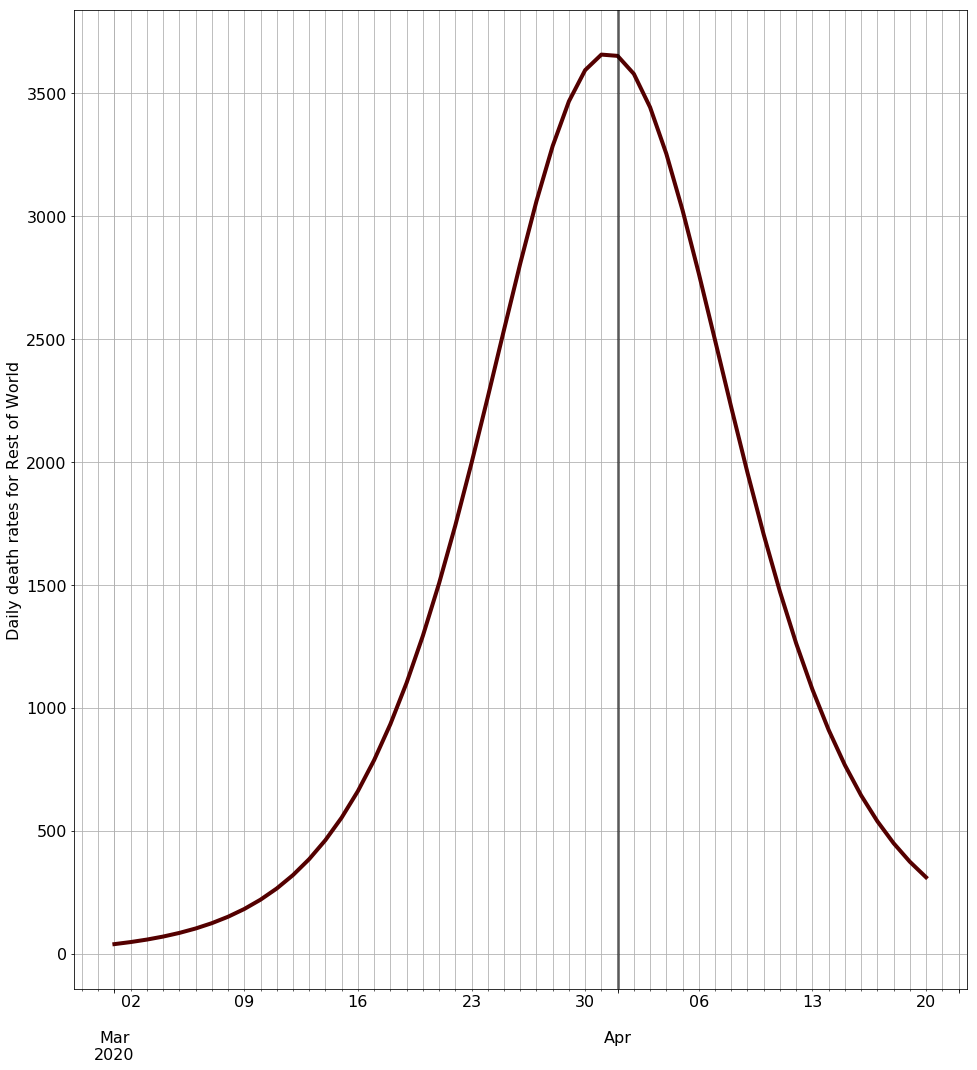

In [212]:
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
fs.diff()["2020/3/1": "2020/4/20"].plot(ax=ax, lw=4, fontsize=16)
ax.axvline(datetime.now(), lw=3, color='k', alpha=0.5)

grid('on', which='both')
ax.set_ylabel('Daily death rates for Rest of World', fontsize=16)

In [213]:
fs.diff().max()

3657.6966286240713

### Take a closer look at Italy death rates as looks like they are past the inflection point

Text(0, 0.5, 'Italian deaths per day')

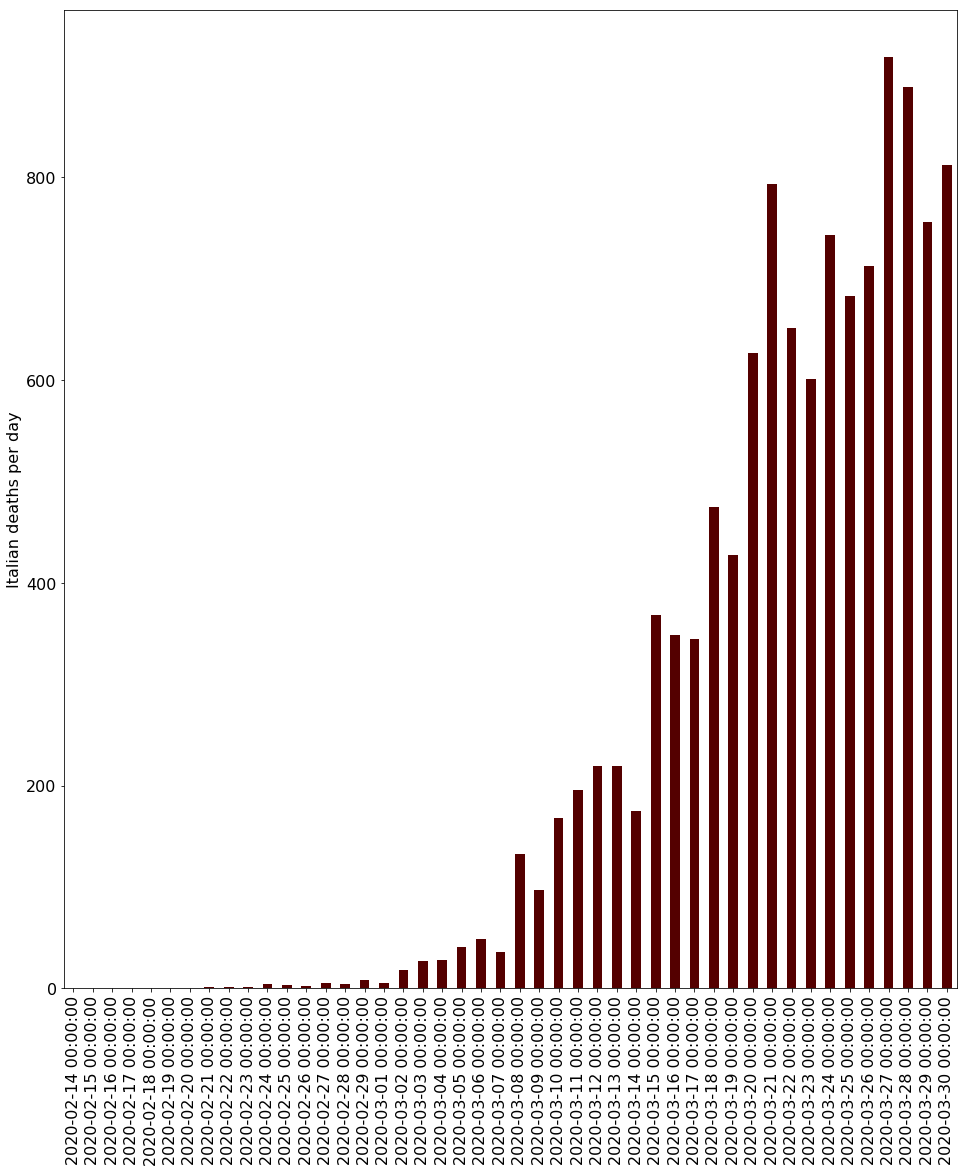

In [218]:
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
RoW_D2.diff()['Italy']["2020/2/14":].plot(kind='bar', ax=ax, color=c_p['br1'], fontsize=16)
ax.set_ylabel('Italian deaths per day', fontsize=16)

### Attempt to fit data to those countries with over 1000 deaths (we need more data for a fit)

In [219]:
RoW_1000 = RoW_D2.loc[:, RoW_D2.iloc[-1,:] >= 1000]
country_1000 = list(RoW_1000.iloc[-1,:].index)
country_sigmoids={}
for c in country_1000:
    try:
        print(c)
        country_sigmoids[c] = fit_sigmoid(RoW_D2[c], p0=[175000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1))
    except:
        print('Fit for ' + c + ' failed!')
        pass
    

country_sigmoids = pd.concat(country_sigmoids, axis=1)

France
[175000, 737522.0, 0.305, 10]
Iran
[175000, 737522.0, 0.305, 10]
Italy
[175000, 737522.0, 0.305, 10]
Spain
[175000, 737522.0, 0.305, 10]
US
[175000, 737522.0, 0.305, 10]
United Kingdom
[175000, 737522.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


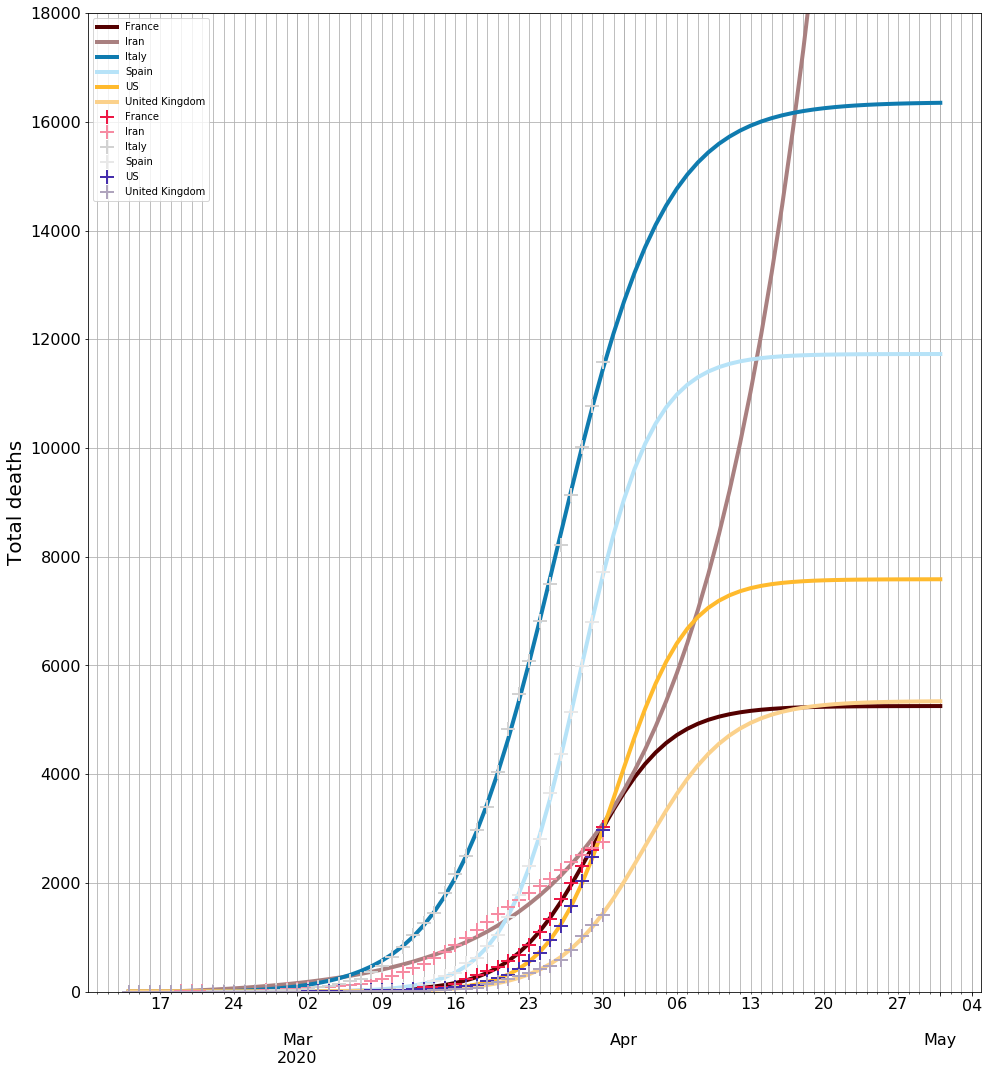

In [220]:
str_d = "2020/2/14"
end_d = "2020/5/1"
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
country_sigmoids.xs('Forecast', level=1, axis=1)[str_d: end_d].plot(ax=ax, lw=4, fontsize=16)
country_sigmoids.xs('Reported', level=1, axis=1)[str_d: end_d].plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
ax.set_ylim([0, 18000])
ax.set_ylabel('Total deaths', fontsize=20)

grid('on', which='both')

As illustrated Iran data does not fit well - other than that the rest look to fit well.  Spain and Italy are past the inflection point so these forecasts are likely to be reasonably accurate... US and France getting close to inflection points...

We can re-calculate mortality rates based on each individual countries forecast, then interpolate for NZ population.   

### Crude mortality rates per-million

In [224]:
total_forecast_deaths = country_sigmoids.xs('Forecast', axis=1, level=1).iloc[-1, :]
crude_mortality = 1e6*total_forecast_deaths/pop[total_forecast_deaths.index]
crude_mortality.map(lambda x: int(np.ceil(x)))

France               72
Iran              10600
Italy               242
Spain               230
US                   22
United Kingdom       77
dtype: int64

### Potential NZ deaths based on above mortality rates

In [225]:
potential_NZ_deaths = (NZ_pop/1e6)*crude_mortality
potential_NZ_deaths.map(lambda x: int(x))

France              347
Iran              51115
Italy              1165
Spain              1108
US                  105
United Kingdom      369
dtype: int64

### if the world follows above mortality rates?

In [226]:
potential_world_deaths = (pop.sum()/1e6)*crude_mortality
potential_world_deaths.map(lambda x: int(x))

France              561513
Iran              82679386
Italy              1885685
Spain              1793354
US                  170034
United Kingdom      598130
dtype: int64

### Fit Sigmoid to death rate?

So far we have used sigmoid curves on a selection of the population where COVID-19 has caused significant deaths.  We have then used this data to forecast into the near term future how many deaths might occur in the near future.  This approach seems reasonable.

But, what if we fit a sigmoid to the daily death rate?  If we then intergrate this curve to get cumulative deaths for the rest of the world - i.e., all of the world population minus China.

An implicit assumption, that may be incorrect, is that many distributed sigmoids/normal death curves all time shifted depending on each countries situation, will cancel out the exponential increase in death rates and therefore we may see a more linear type growth rate, or, constant death rate for some months until we reach the current forecast limit we determined above based on countries with over 100 deaths, or pop_pc % of world population).

Lets do this now.

[275000, 737530.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


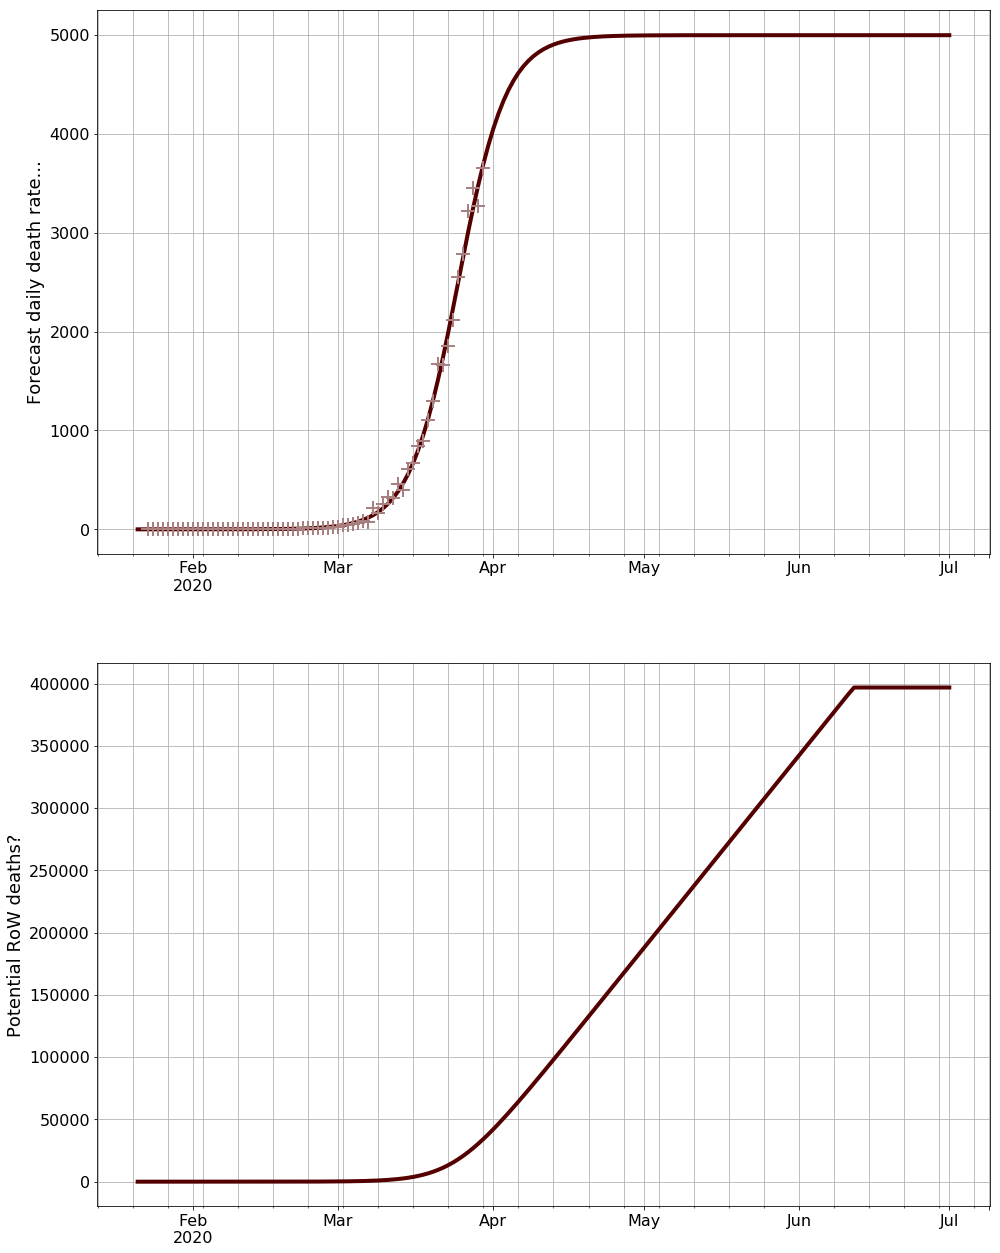

In [236]:

end_date = datetime(2020,7,1)
fs_row_daily_rate = fit_sigmoid(RoW_D2.sum(axis=1).diff().rolling(1).mean().dropna(), p0=[275000, date2num(datetime(2020,4,15)), 0.305, 10],
                                end_date=datetime(2021,1,1))

fig = plt.figure(1, figsize=[16,22])
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

fs_row_daily_rate.Forecast[:end_date].plot(ax=ax, lw=4, fontsize=16 )
fs_row_daily_rate.Reported[:end_date].plot(ax=ax,marker="+", lw=0, ms=14, mew=2)

ax.grid('on', which='both')
ax.set_ylabel('Forecast daily death rate...', fontsize=18)
ax2.set_ylabel('Potential RoW deaths?', fontsize=18)
fs_cumsum = fs_row_daily_rate.Forecast.cumsum()

#assume max limit from above estimate
fs_cumsum[fs_cumsum>all_of_world]=all_of_world
fs_cumsum[:end_date].plot(ax=ax2, lw=4, fontsize=16)

grid('on', which='both')

This is probably a worst-case forecast as we assume a constant death rate once it hits the asymptote, whereas in reality the deaths will start reducing.  A consequence is that deaths will probably continue longer than indicated here... but at a slower rate.